In [3]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')  

os.chdir("/content/drive/My Drive/")
sys.path.append("/content/drive/My Drive/")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:


## Python
import os
import random
import sys


## Package
import glob 
import keras
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as py
import plotly.tools as tls
import seaborn as sns
import scipy.io.wavfile
import tensorflow as tf
py.init_notebook_mode(connected=True)


## Keras
from keras import regularizers
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.callbacks import  History, ReduceLROnPlateau, CSVLogger
from keras.models import Model, Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
from keras.utils import to_categorical


## Sklearn
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder


## Rest
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
from tqdm import tqdm

input_duration=3
# % pylab inline

In [5]:
!pwd

/content/drive/My Drive


In [6]:
dir_list = os.listdir('/content/drive/My Drive/aud/')
dir_list.sort()
print (dir_list)

['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']


In [7]:
# Create DataFrame for Data intel
data_df = pd.DataFrame(columns=['path', 'source', 'actor', 'gender',
                                'intensity', 'statement', 'repetition', 'emotion'])
count = 0
for i in dir_list:
    file_list = os.listdir('aud/' + i)
    for f in file_list:
        nm = f.split('.')[0].split('-')
        path = 'aud/' + i + '/' + f
        src = int(nm[1])
        actor = int(nm[-1])
        emotion = int(nm[2])
        
        if int(actor)%2 == 0:
            gender = "female"
        else:
            gender = "male"
        
        if nm[3] == '01':
            intensity = 0
        else:
            intensity = 1
        
        if nm[4] == '01':
            statement = 0
        else:
            statement = 1
        
        if nm[5] == '01':
            repeat = 0
        else:
            repeat = 1
            
        data_df.loc[count] = [path, src, actor, gender, intensity, statement, repeat, emotion]
        count += 1

In [8]:
print (len(data_df))
data_df.head()

2452


,path,source,actor,gender,intensity,statement,repetition,emotion
0,aud/Actor_01/03-01-01-01-01-02-01.wav,1,1,male,0,0,1,1
1,aud/Actor_01/03-01-02-01-01-01-01.wav,1,1,male,0,0,0,2
2,aud/Actor_01/03-01-01-01-01-01-01.wav,1,1,male,0,0,0,1
3,aud/Actor_01/03-01-02-02-01-01-01.wav,1,1,male,1,0,0,2
4,aud/Actor_01/03-01-02-01-02-01-01.wav,1,1,male,0,1,0,2


In [9]:
filename = data_df.path[1021]
print (filename)

samples, sample_rate = librosa.load(filename)
sample_rate, samples

aud/Actor_10/03-02-04-02-01-01-10.wav


(22050, array([-1.9825895e-04, -1.3461124e-04,  1.2506393e-04, ...,
        -1.5266687e-05, -8.9759606e-06,  0.0000000e+00], dtype=float32))

In [10]:
len(samples), sample_rate

(118454, 22050)

In [11]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

In [12]:
sample_rate/ len(samples)

0.18614820943150928

Text(0.5, 0, 'Seconds')

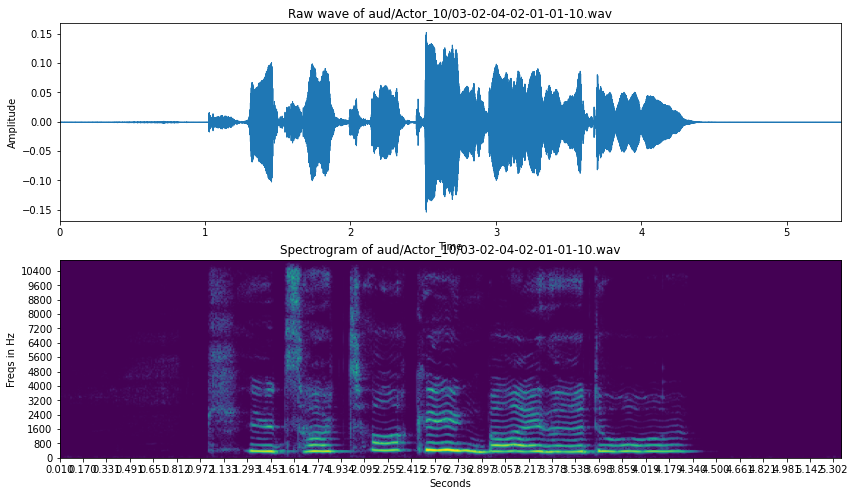

In [13]:
# Plotting Wave Form and Spectrogram
freqs, times, spectrogram = log_specgram(samples, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
librosa.display.waveplot(samples, sr=sample_rate)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')


In [14]:
mean = np.mean(spectrogram, axis=0)
std = np.std(spectrogram, axis=0)
spectrogram = (spectrogram - mean) / std

In [15]:

# Trim the silence voice
aa , bb = librosa.effects.trim(samples, top_db=30)
aa, bb

(array([-2.8575119e-05,  1.8996350e-04,  3.8745056e-05, ...,
        -1.9082761e-03, -1.9263441e-03, -1.9740448e-03], dtype=float32),
 array([22528, 95744]))

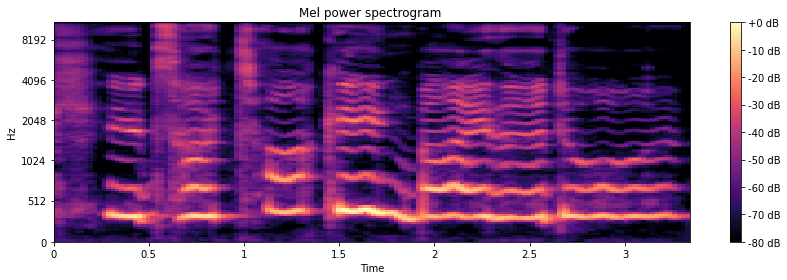

In [16]:
# Plotting Mel Power Spectrogram
S = librosa.feature.melspectrogram(aa, sr=sample_rate, n_mels=128)

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

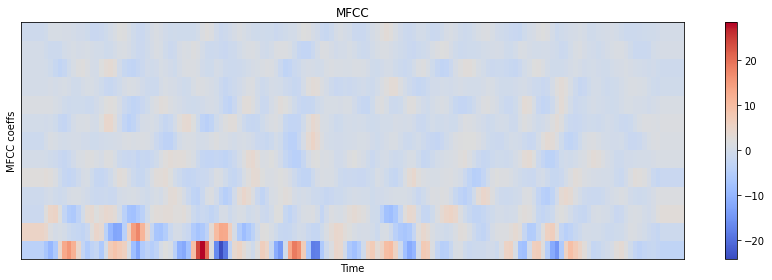

In [17]:
# Plotting MFCC
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

# Let's pad on the first and second deltas while we're at it
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(12, 4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

In [18]:
# Original Sound
ipd.Audio(samples, rate=sample_rate)

In [19]:
# Silence trimmed Sound by librosa.effects.trim()
ipd.Audio(aa, rate=sample_rate)

In [20]:
# Silence trimmed Sound by manuel trimmin
samples_cut = samples[10000:-12500]
ipd.Audio(samples_cut, rate=sample_rate)

In [21]:
# 2 class: Positive & Negative

# Positive: Calm, Happy
# Negative: Angry, Fearful, Sad

label2_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 2: # Calm
        lb = "_positive"
    elif data_df.emotion[i] == 3: # Happy
        lb = "_positive"
    elif data_df.emotion[i] == 4: # Sad
        lb = "_negative"
    elif data_df.emotion[i] == 5: # Angry
        lb = "_negative"
    elif data_df.emotion[i] == 6: # Fearful
        lb = "_negative"
    else:
        lb = "_none"
        
    # Add gender to the label    
    label2_list.append(data_df.gender[i] + lb)
    
len(label2_list)

2452

In [22]:
#3 class: Positive, Neutral & Negative

# Positive:  Happy
# Negative: Angry, Fearful, Sad
# Neutral: Calm, Neutral

label3_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 1: # Neutral
        lb = "_neutral"
    elif data_df.emotion[i] == 2: # Calm
        lb = "_neutral"
    elif data_df.emotion[i] == 3: # Happy
        lb = "_positive"
    elif data_df.emotion[i] == 4: # Sad
        lb = "_negative"
    elif data_df.emotion[i] == 5: # Angry
        lb = "_negative"
    elif data_df.emotion[i] == 6: # Fearful
        lb = "_negative"
    else:
        lb = "_none"
    
    # Add gender to the label  
    label3_list.append(data_df.gender[i] + lb)
    
len(label3_list)

2452

In [23]:
# 5 class: angry, calm, sad, happy & fearful
label5_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 2:
        lb = "_calm"
    elif data_df.emotion[i] == 3:
        lb = "_happy"
    elif data_df.emotion[i] == 4:
        lb = "_sad"
    elif data_df.emotion[i] == 5:
        lb = "_angry"
    elif data_df.emotion[i] == 6:
        lb = "_fearful"    
    else:
        lb = "_none"
    
    # Add gender to the label  
    label5_list.append(data_df.gender[i] + lb)
    
len(label5_list)

2452

In [24]:

# All class

label8_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 1:
        lb = "_neutral"
    elif data_df.emotion[i] == 2:
        lb = "_calm"
    elif data_df.emotion[i] == 3:
        lb = "_happy"
    elif data_df.emotion[i] == 4:
        lb = "_sad"
    elif data_df.emotion[i] == 5:
        lb = "_angry"
    elif data_df.emotion[i] == 6:
        lb = "_fearful"
    elif data_df.emotion[i] == 7:
        lb = "_disgust"
    elif data_df.emotion[i] == 8:
        lb = "_surprised"
    else:
        lb = "_none"
        
    # Add gender to the label 
    label8_list.append(data_df.gender[i]  + lb)
    
len(label8_list)

2452

In [25]:
# Select the label set you want by commenting the unwanteds.

data_df['label'] = label2_list
# data_df['label'] = label3_list
# data_df['label'] = label5_list
# data_df['label'] = label8_list
data_df.head()

,path,source,actor,gender,intensity,statement,repetition,emotion,label
0,aud/Actor_01/03-01-01-01-01-02-01.wav,1,1,male,0,0,1,1,male_none
1,aud/Actor_01/03-01-02-01-01-01-01.wav,1,1,male,0,0,0,2,male_positive
2,aud/Actor_01/03-01-01-01-01-01-01.wav,1,1,male,0,0,0,1,male_none
3,aud/Actor_01/03-01-02-02-01-01-01.wav,1,1,male,1,0,0,2,male_positive
4,aud/Actor_01/03-01-02-01-02-01-01.wav,1,1,male,0,1,0,2,male_positive


In [26]:
print (data_df.label.value_counts().keys())

Index(['male_negative', 'female_negative', 'male_positive', 'female_positive',
       'male_none', 'female_none'],
      dtype='object')


In [27]:
# Plotting the emotion distribution

def plot_emotion_dist(dist, color_code='#C2185B', title="Plot"):
    """
    To plot the data distributioin by class.
    Arg:
      dist: pandas series of label count. 
    """
    tmp_df = pd.DataFrame()
    tmp_df['Emotion'] = list(dist.keys())
    tmp_df['Count'] = list(dist)
    fig, ax = plt.subplots(figsize=(14, 7))
    ax = sns.barplot(x="Emotion", y='Count', color=color_code, data=tmp_df)
    ax.set_title(title)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

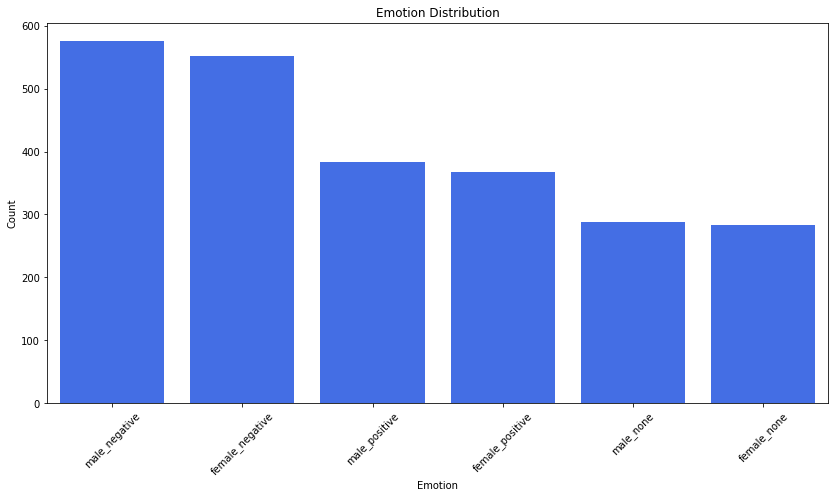

In [28]:
a = data_df.label.value_counts()
plot_emotion_dist(a, "#2962FF", "Emotion Distribution")

In [29]:

# Female Data Set

## Uncomment all below to use Female set 
'''data2_df = data_df.copy()
data2_df = data2_df[data2_df.label != "male_none"]
data2_df = data2_df[data2_df.label != "female_none"]
data2_df = data2_df[data2_df.label != "male_happy"]
data2_df = data2_df[data2_df.label != "male_angry"]
data2_df = data2_df[data2_df.label != "male_sad"]
data2_df = data2_df[data2_df.label != "male_fearful"]
data2_df = data2_df[data2_df.label != "male_calm"]
data2_df = data2_df[data2_df.label != "male_positive"]
data2_df = data2_df[data2_df.label != "male_negative"].reset_index(drop=True)

tmp1 = data2_df[data2_df.actor == 22]
tmp2 = data2_df[data2_df.actor == 24]
data3_df = pd.concat([tmp1, tmp2],ignore_index=True).reset_index(drop=True)
data2_df = data2_df[data2_df.actor != 22]
data2_df = data2_df[data2_df.actor != 24].reset_index(drop=True)
print (len(data2_df))
data2_df.head()'''

'data2_df = data_df.copy()\ndata2_df = data2_df[data2_df.label != "male_none"]\ndata2_df = data2_df[data2_df.label != "female_none"]\ndata2_df = data2_df[data2_df.label != "male_happy"]\ndata2_df = data2_df[data2_df.label != "male_angry"]\ndata2_df = data2_df[data2_df.label != "male_sad"]\ndata2_df = data2_df[data2_df.label != "male_fearful"]\ndata2_df = data2_df[data2_df.label != "male_calm"]\ndata2_df = data2_df[data2_df.label != "male_positive"]\ndata2_df = data2_df[data2_df.label != "male_negative"].reset_index(drop=True)\n\ntmp1 = data2_df[data2_df.actor == 22]\ntmp2 = data2_df[data2_df.actor == 24]\ndata3_df = pd.concat([tmp1, tmp2],ignore_index=True).reset_index(drop=True)\ndata2_df = data2_df[data2_df.actor != 22]\ndata2_df = data2_df[data2_df.actor != 24].reset_index(drop=True)\nprint (len(data2_df))\ndata2_df.head()'

In [30]:
# Male Data Set

## Uncomment all below to use Male set 

data2_df = data_df.copy()
data2_df = data2_df[data2_df.label != "male_none"]
data2_df = data2_df[data2_df.label != "female_none"].reset_index(drop=True)
data2_df = data2_df[data2_df.label != "female_neutral"]
data2_df = data2_df[data2_df.label != "female_happy"]
data2_df = data2_df[data2_df.label != "female_angry"]
data2_df = data2_df[data2_df.label != "female_sad"]
data2_df = data2_df[data2_df.label != "female_fearful"]
data2_df = data2_df[data2_df.label != "female_calm"]
data2_df = data2_df[data2_df.label != "female_positive"]
data2_df = data2_df[data2_df.label != "female_negative"].reset_index(drop=True)

tmp1 = data2_df[data2_df.actor == 21]
tmp2 = data2_df[data2_df.actor == 22]
tmp3 = data2_df[data2_df.actor == 23]
tmp4 = data2_df[data2_df.actor == 24]
data3_df = pd.concat([tmp1, tmp3],ignore_index=True).reset_index(drop=True)
data2_df = data2_df[data2_df.actor != 21]
data2_df = data2_df[data2_df.actor != 22]
data2_df = data2_df[data2_df.actor != 23].reset_index(drop=True)
data2_df = data2_df[data2_df.actor != 24].reset_index(drop=True)
print (len(data2_df))
data2_df.head()

800


,path,source,actor,gender,intensity,statement,repetition,emotion,label
0,aud/Actor_01/03-01-02-01-01-01-01.wav,1,1,male,0,0,0,2,male_positive
1,aud/Actor_01/03-01-02-02-01-01-01.wav,1,1,male,1,0,0,2,male_positive
2,aud/Actor_01/03-01-02-01-02-01-01.wav,1,1,male,0,1,0,2,male_positive
3,aud/Actor_01/03-01-02-01-01-02-01.wav,1,1,male,0,0,1,2,male_positive
4,aud/Actor_01/03-01-02-01-02-02-01.wav,1,1,male,0,1,1,2,male_positive


In [31]:

print (len(data3_df))
data3_df.head()

160


,path,source,actor,gender,intensity,statement,repetition,emotion,label
0,aud/Actor_21/03-01-02-01-01-01-21.wav,1,21,male,0,0,0,2,male_positive
1,aud/Actor_21/03-01-02-01-01-02-21.wav,1,21,male,0,0,1,2,male_positive
2,aud/Actor_21/03-01-03-01-02-02-21.wav,1,21,male,0,1,1,3,male_positive
3,aud/Actor_21/03-01-03-01-01-01-21.wav,1,21,male,0,0,0,3,male_positive
4,aud/Actor_21/03-01-03-01-02-01-21.wav,1,21,male,0,1,0,3,male_positive


In [32]:

data = pd.DataFrame(columns=['feature'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
#     X = X[10000:90000]
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    feature = mfccs
    data.loc[i] = [feature]

100%|██████████| 800/800 [06:15<00:00,  2.13it/s]


In [33]:
data.head()

,feature
0,"[-70.2677641610773, -70.2677641610773, -70.267..."
1,"[-73.8413701111492, -73.8413701111492, -73.841..."
2,"[-69.67328949566405, -69.69331084873151, -69.6..."
3,"[-67.55739512198222, -67.55739512198222, -67.5..."
4,"[-69.05139995492158, -69.05139995492158, -69.0..."


In [34]:
df3 = pd.DataFrame(data['feature'].values.tolist())
labels = data2_df.label

In [35]:

df3.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258
0,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.000654,-69.980825,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-66.096389,-63.397296,-68.259889,-70.267764,-69.665259,-68.817130,-66.114668,-63.901026,-68.620616,-70.267764,-69.641987,-68.420153,-70.044184,-67.232467,-66.350391,-68.503458,-66.577591,-62.980961,-62.693481,-65.906674,...,-61.326124,-60.893419,-63.767978,-62.977461,-61.404842,-63.950093,-65.938513,-69.175473,-61.678368,-61.514545,-66.917599,-69.971884,-70.267764,-70.267764,-69.274984,-69.495429,-70.267764,-70.102100,-70.267764,-69.902895,-70.267764,-69.916430,-69.471635,-68.002293,-67.983570,-70.267764,-70.267764,-68.205641,-64.099158,-67.300317,-70.267764,-70.267764,-69.957707,-68.377602,-69.862569,-70.267764,-70.122135,-68.554960,-70.206530,-70.267764
1,-73.841370,-73.841370,-73.841370,-73.719655,-73.841370,-73.841370,-73.841370,-73.303635,-72.806811,-73.841370,-73.841370,-73.317791,-65.746239,-64.290707,-63.904499,-62.023985,-61.680303,-60.364077,-62.794824,-71.038866,-67.588028,-70.089217,-71.925180,-72.205022,-73.841370,-71.766112,-69.864632,-65.666615,-62.791278,-60.527114,-62.275716,-64.324743,-65.297140,-67.774274,-66.401675,-64.908754,-62.807495,-58.840394,-54.097902,-53.170769,...,-63.579686,-61.875581,-62.231173,-68.945617,-68.553264,-70.950624,-73.375259,-73.751453,-73.841370,-70.395539,-65.798634,-67.672699,-70.216733,-73.574817,-73.841370,-73.804057,-73.554967,-73.421475,-73.841370,-73.113901,-73.535400,-73.841370,-73.841370,-73.841370,-67.686863,-65.191740,-71.053125,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370
2,-69.673289,-69.693311,-69.693311,-69.693311,-69.693311,-69.693311,-69.693311,-69.620774,-69.693311,-68.906572,-67.251427,-69.333558,-69.693311,-69.693311,-69.647573,-69.679308,-69.693311,-69.588926,-69.181253,-66.818492,-65.784794,-69.063563,-69.693311,-64.038489,-58.784480,-59.416517,-66.427642,-69.693311,-67.027641,-62.696477,-58.779407,-59.776407,-59.815429,-63.297572,-63.207493,-60.560481,-60.138096,-59.228013,-55.839270,-55.880688,...,-59.614006,-61.407597,-65.880793,-67.005638,-67.784206,-69.394296,-66.819434,-65.475747,-67.264374,-68.830622,-69.693311,-69.693311,-69.693311,-69.693311,-69.693311,-69.693311,-69.693311,-69.693311,-69.693311,-69.693311,-69.693311,-67.485033,-66.369551,-69.693311,-69.005508,-68.879502,-69.693311,-69.693311,-69.693311,-69.693311,-69.693311,-69.693311,-69.693311,-69.693311,-69.693311,-69.383522,-69.693311,-69.693311,-69.693311,-69.693311
3,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-65.239801,-65.536197,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.207014,-63.987660,-63.159425,-65.259766,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-65.524410,-61.292170,-57.662596,...,-60.530318,-65.795279,-66.635188,-67.428688,-65.402662,-61.771986,-61.545257,-62.659329,-66.034690,-66.366576,-66.321754,-67.027766,-67.557395,-67.111325,-66.606260,-67.557395,-67.557395,-67.557395,-67.175422,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.126574,-67.557395
4,-69.051400,-69.051400,-69.051400,-69.051400,-69.051400,-68.754863,-69.051400,-69.051400,-69.051400,-68.359101,-68.878747,-69.051400,-68.493403,-67.109979,-66.994458,-68.018142,-66

In [36]:

newdf = pd.concat([df3,labels], axis=1)

In [37]:

rnewdf = newdf.rename(index=str, columns={"0": "label"})
len(rnewdf)

800

In [38]:
rnewdf.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,label
0,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.000654,-69.980825,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-66.096389,-63.397296,-68.259889,-70.267764,-69.665259,-68.817130,-66.114668,-63.901026,-68.620616,-70.267764,-69.641987,-68.420153,-70.044184,-67.232467,-66.350391,-68.503458,-66.577591,-62.980961,-62.693481,-65.906674,...,-60.893419,-63.767978,-62.977461,-61.404842,-63.950093,-65.938513,-69.175473,-61.678368,-61.514545,-66.917599,-69.971884,-70.267764,-70.267764,-69.274984,-69.495429,-70.267764,-70.102100,-70.267764,-69.902895,-70.267764,-69.916430,-69.471635,-68.002293,-67.983570,-70.267764,-70.267764,-68.205641,-64.099158,-67.300317,-70.267764,-70.267764,-69.957707,-68.377602,-69.862569,-70.267764,-70.122135,-68.554960,-70.206530,-70.267764,male_positive
1,-73.841370,-73.841370,-73.841370,-73.719655,-73.841370,-73.841370,-73.841370,-73.303635,-72.806811,-73.841370,-73.841370,-73.317791,-65.746239,-64.290707,-63.904499,-62.023985,-61.680303,-60.364077,-62.794824,-71.038866,-67.588028,-70.089217,-71.925180,-72.205022,-73.841370,-71.766112,-69.864632,-65.666615,-62.791278,-60.527114,-62.275716,-64.324743,-65.297140,-67.774274,-66.401675,-64.908754,-62.807495,-58.840394,-54.097902,-53.170769,...,-61.875581,-62.231173,-68.945617,-68.553264,-70.950624,-73.375259,-73.751453,-73.841370,-70.395539,-65.798634,-67.672699,-70.216733,-73.574817,-73.841370,-73.804057,-73.554967,-73.421475,-73.841370,-73.113901,-73.535400,-73.841370,-73.841370,-73.841370,-67.686863,-65.191740,-71.053125,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,male_positive
2,-69.673289,-69.693311,-69.693311,-69.693311,-69.693311,-69.693311,-69.693311,-69.620774,-69.693311,-68.906572,-67.251427,-69.333558,-69.693311,-69.693311,-69.647573,-69.679308,-69.693311,-69.588926,-69.181253,-66.818492,-65.784794,-69.063563,-69.693311,-64.038489,-58.784480,-59.416517,-66.427642,-69.693311,-67.027641,-62.696477,-58.779407,-59.776407,-59.815429,-63.297572,-63.207493,-60.560481,-60.138096,-59.228013,-55.839270,-55.880688,...,-61.407597,-65.880793,-67.005638,-67.784206,-69.394296,-66.819434,-65.475747,-67.264374,-68.830622,-69.693311,-69.693311,-69.693311,-69.693311,-69.693311,-69.693311,-69.693311,-69.693311,-69.693311,-69.693311,-69.693311,-67.485033,-66.369551,-69.693311,-69.005508,-68.879502,-69.693311,-69.693311,-69.693311,-69.693311,-69.693311,-69.693311,-69.693311,-69.693311,-69.693311,-69.383522,-69.693311,-69.693311,-69.693311,-69.693311,male_positive
3,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-65.239801,-65.536197,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.207014,-63.987660,-63.159425,-65.259766,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-65.524410,-61.292170,-57.662596,...,-65.795279,-66.635188,-67.428688,-65.402662,-61.771986,-61.545257,-62.659329,-66.034690,-66.366576,-66.321754,-67.027766,-67.557395,-67.111325,-66.606260,-67.557395,-67.557395,-67.557395,-67.175422,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.126574,-67.557395,male_positive
4,-69.051400,-69.051400,-69.051400,-69.051400,-69.051400,-68.754863,-69.051400,-69.051400,-69.051400,-68.359101,-68.878747,-69.051400,-68.493403,-67.109979,-66.994458,

In [39]:
rnewdf.isnull().sum().sum()

2284

In [40]:

rnewdf = rnewdf.fillna(0)
rnewdf.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,label
0,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.000654,-69.980825,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-66.096389,-63.397296,-68.259889,-70.267764,-69.665259,-68.817130,-66.114668,-63.901026,-68.620616,-70.267764,-69.641987,-68.420153,-70.044184,-67.232467,-66.350391,-68.503458,-66.577591,-62.980961,-62.693481,-65.906674,...,-60.893419,-63.767978,-62.977461,-61.404842,-63.950093,-65.938513,-69.175473,-61.678368,-61.514545,-66.917599,-69.971884,-70.267764,-70.267764,-69.274984,-69.495429,-70.267764,-70.102100,-70.267764,-69.902895,-70.267764,-69.916430,-69.471635,-68.002293,-67.983570,-70.267764,-70.267764,-68.205641,-64.099158,-67.300317,-70.267764,-70.267764,-69.957707,-68.377602,-69.862569,-70.267764,-70.122135,-68.554960,-70.206530,-70.267764,male_positive
1,-73.841370,-73.841370,-73.841370,-73.719655,-73.841370,-73.841370,-73.841370,-73.303635,-72.806811,-73.841370,-73.841370,-73.317791,-65.746239,-64.290707,-63.904499,-62.023985,-61.680303,-60.364077,-62.794824,-71.038866,-67.588028,-70.089217,-71.925180,-72.205022,-73.841370,-71.766112,-69.864632,-65.666615,-62.791278,-60.527114,-62.275716,-64.324743,-65.297140,-67.774274,-66.401675,-64.908754,-62.807495,-58.840394,-54.097902,-53.170769,...,-61.875581,-62.231173,-68.945617,-68.553264,-70.950624,-73.375259,-73.751453,-73.841370,-70.395539,-65.798634,-67.672699,-70.216733,-73.574817,-73.841370,-73.804057,-73.554967,-73.421475,-73.841370,-73.113901,-73.535400,-73.841370,-73.841370,-73.841370,-67.686863,-65.191740,-71.053125,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,male_positive
2,-69.673289,-69.693311,-69.693311,-69.693311,-69.693311,-69.693311,-69.693311,-69.620774,-69.693311,-68.906572,-67.251427,-69.333558,-69.693311,-69.693311,-69.647573,-69.679308,-69.693311,-69.588926,-69.181253,-66.818492,-65.784794,-69.063563,-69.693311,-64.038489,-58.784480,-59.416517,-66.427642,-69.693311,-67.027641,-62.696477,-58.779407,-59.776407,-59.815429,-63.297572,-63.207493,-60.560481,-60.138096,-59.228013,-55.839270,-55.880688,...,-61.407597,-65.880793,-67.005638,-67.784206,-69.394296,-66.819434,-65.475747,-67.264374,-68.830622,-69.693311,-69.693311,-69.693311,-69.693311,-69.693311,-69.693311,-69.693311,-69.693311,-69.693311,-69.693311,-69.693311,-67.485033,-66.369551,-69.693311,-69.005508,-68.879502,-69.693311,-69.693311,-69.693311,-69.693311,-69.693311,-69.693311,-69.693311,-69.693311,-69.693311,-69.383522,-69.693311,-69.693311,-69.693311,-69.693311,male_positive
3,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-65.239801,-65.536197,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.207014,-63.987660,-63.159425,-65.259766,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-65.524410,-61.292170,-57.662596,...,-65.795279,-66.635188,-67.428688,-65.402662,-61.771986,-61.545257,-62.659329,-66.034690,-66.366576,-66.321754,-67.027766,-67.557395,-67.111325,-66.606260,-67.557395,-67.557395,-67.557395,-67.175422,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.126574,-67.557395,male_positive
4,-69.051400,-69.051400,-69.051400,-69.051400,-69.051400,-68.754863,-69.051400,-69.051400,-69.051400,-68.359101,-68.878747,-69.051400,-68.493403,-67.109979,-66.994458,

In [41]:
def plot_time_series(data):
    """
    Plot the Audio Frequency.
    """
    fig = plt.figure(figsize=(14, 8))
    plt.title('Raw wave ')
    plt.ylabel('Amplitude')
    plt.plot(np.linspace(0, 1, len(data)), data)
    plt.show()


def noise(data):
    """
    Adding White Noise.
    """
    # you can take any distribution from https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.random.html
    noise_amp = 0.005*np.random.uniform()*np.amax(data)
    data = data.astype('float64') + noise_amp * np.random.normal(size=data.shape[0])
    return data
    
def shift(data):
    """
    Random Shifting.
    """
    s_range = int(np.random.uniform(low=-5, high = 5)*500)
    return np.roll(data, s_range)
    
def stretch(data, rate=0.8):
    """
    Streching the Sound.
    """
    data = librosa.effects.time_stretch(data, rate)
    return data
    
def pitch(data, sample_rate):
    """
    Pitch Tuning.
    """
    bins_per_octave = 12
    pitch_pm = 2
    pitch_change =  pitch_pm * 2*(np.random.uniform())   
    data = librosa.effects.pitch_shift(data.astype('float64'), 
                                      sample_rate, n_steps=pitch_change, 
                                      bins_per_octave=bins_per_octave)
    return data
    
def dyn_change(data):
    """
    Random Value Change.
    """
    dyn_change = np.random.uniform(low=1.5,high=3)
    return (data * dyn_change)
    
def speedNpitch(data):
    """
    peed and Pitch Tuning.
    """
    # you can change low and high here
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.0  / length_change
    tmp = np.interp(np.arange(0,len(data),speed_fac),np.arange(0,len(data)),data)
    minlen = min(data.shape[0], tmp.shape[0])
    data *= 0
    data[0:minlen] = tmp[0:minlen]
    return data

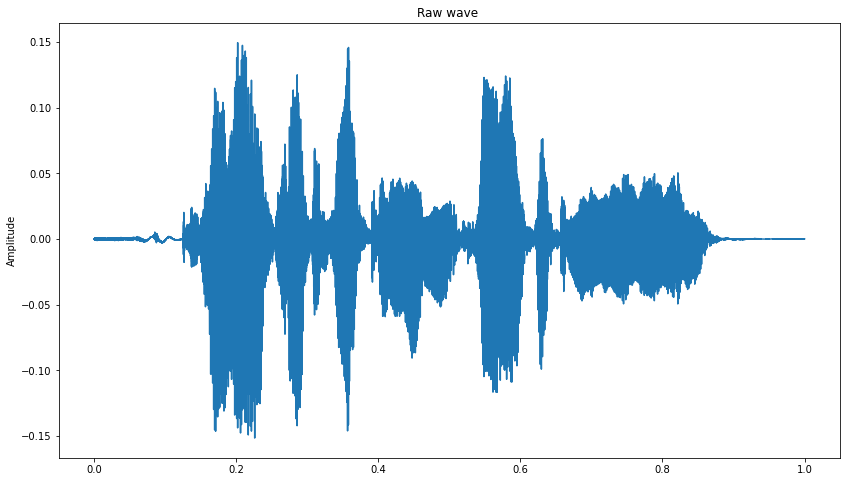

In [42]:

X, sample_rate = librosa.load(data2_df.path[216], res_type='kaiser_fast',duration=4,sr=22050*2,offset=0.5)
plot_time_series(X)
ipd.Audio(X, rate=sample_rate)

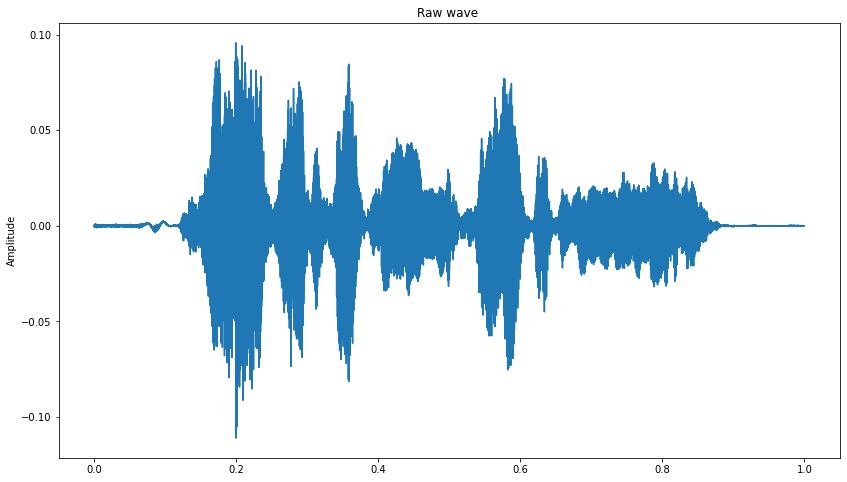

In [43]:
x = pitch(X, sample_rate)
plot_time_series(x)
ipd.Audio(x, rate=sample_rate)

In [44]:
# Augmentation Method 1
syn_data1 = pd.DataFrame(columns=['feature', 'label'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
    if data2_df.label[i]:
#     if data2_df.label[i] == "male_positive":
        X = noise(X)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        syn_data1.loc[i] = [feature, data2_df.label[i]]


100%|██████████| 800/800 [02:30<00:00,  5.31it/s]


In [45]:
# Augmentation Method 2

syn_data2 = pd.DataFrame(columns=['feature', 'label'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
    if data2_df.label[i]:
#     if data2_df.label[i] == "male_positive":
        X = pitch(X, sample_rate)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        syn_data2.loc[i] = [feature, data2_df.label[i]]

100%|██████████| 800/800 [04:41<00:00,  2.84it/s]


In [46]:
len(syn_data1), len(syn_data2)

(800, 800)

In [47]:
syn_data1 = syn_data1.reset_index(drop=True)
syn_data2 = syn_data2.reset_index(drop=True)

In [48]:
df4 = pd.DataFrame(syn_data1['feature'].values.tolist())
labels4 = syn_data1.label
syndf1 = pd.concat([df4,labels4], axis=1)
syndf1 = syndf1.rename(index=str, columns={"0": "label"})
syndf1 = syndf1.fillna(0)
len(syndf1)

800

In [49]:
syndf1.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,label
0,-62.835964,-62.752039,-60.504776,-60.551131,-62.279018,-60.863376,-61.146558,-63.565861,-59.382714,-58.504237,-59.285848,-60.489543,-62.556851,-62.656752,-60.142259,-58.789470,-58.522436,-59.162417,-60.273469,-58.676814,-57.734324,-58.705453,-60.976396,-60.098970,-62.043833,-62.532845,-61.872769,-60.574333,-61.026450,-59.983042,-60.157824,-60.088340,-59.977057,-60.244762,-60.445632,-59.198899,-58.522071,-56.898892,-58.019191,-59.365762,...,-56.109362,-58.814842,-60.042402,-58.894363,-58.915653,-59.171204,-58.236344,-56.696546,-58.079815,-58.786297,-57.993122,-59.297799,-59.764424,-55.745273,-55.902353,-59.887215,-60.877775,-60.314900,-59.362775,-58.633616,-59.566742,-60.344591,-59.561512,-59.003058,-59.243106,-59.138500,-58.481552,-59.982260,-63.515876,-62.389079,-59.605824,-60.080726,-58.716432,-58.998363,-58.268019,-60.327238,-60.655433,-60.128000,-62.475555,male_positive
1,-68.355015,-67.418441,-66.816142,-65.390178,-66.756214,-68.573743,-69.031739,-69.170770,-69.369586,-68.910048,-67.256387,-67.110095,-63.531945,-63.165076,-61.557954,-58.636826,-60.126660,-58.548308,-60.237297,-66.556638,-65.777074,-66.514113,-68.835394,-69.543015,-69.783596,-68.921034,-66.921143,-64.971480,-62.891861,-59.926695,-61.283214,-62.463533,-64.126919,-64.806863,-65.553548,-63.976600,-60.570430,-57.569847,-53.314940,-52.099613,...,-60.938997,-60.942447,-67.182637,-66.634535,-68.681450,-68.884611,-66.852643,-66.871783,-65.646976,-62.949388,-64.438970,-65.233964,-66.463616,-69.065716,-69.943930,-68.780815,-68.927812,-69.355008,-68.825668,-66.946274,-66.506356,-67.978489,-70.323485,-64.692705,-61.665616,-64.575508,-69.484629,-69.408461,-68.939679,-69.739575,-68.675979,-68.871000,-69.220439,-70.018704,-71.337648,-70.786526,-69.645727,-67.435935,-68.856422,male_positive
2,-53.947556,-53.253631,-54.089339,-52.394753,-51.605395,-53.793300,-53.493855,-52.547645,-52.002842,-50.438139,-51.464572,-53.264329,-53.078091,-52.013957,-50.984022,-52.749241,-54.733781,-56.072551,-54.626442,-53.863425,-53.254680,-53.855214,-54.352408,-53.569461,-51.717546,-51.853358,-53.117884,-54.687000,-54.801621,-53.892423,-53.981328,-52.552619,-52.761590,-53.713429,-51.824504,-54.046404,-53.614582,-53.272673,-48.358585,-49.092632,...,-51.460575,-51.660209,-54.071337,-52.735676,-53.103368,-51.632949,-51.554613,-52.650771,-50.712256,-49.424730,-50.373985,-52.612534,-51.607877,-51.970010,-50.719060,-51.974885,-52.527412,-51.559537,-51.611413,-51.100863,-50.670389,-52.079144,-53.922469,-53.263371,-48.789794,-49.694488,-52.501903,-53.472115,-53.924565,-53.657993,-53.598840,-54.767137,-52.173308,-50.672955,-51.412228,-51.027450,-53.596825,-57.275163,-55.072087,male_positive
3,-58.751213,-57.740660,-58.431125,-58.957825,-59.051852,-57.941826,-59.379578,-60.323248,-56.521326,-54.823939,-55.075222,-56.764985,-59.635258,-57.414574,-56.761736,-56.185973,-55.317121,-56.895163,-55.795611,-55.470220,-55.854976,-56.057177,-56.042415,-57.435349,-59.224028,-60.978563,-60.602662,-56.847540,-56.622885,-55.781529,-54.980723,-60.716190,-58.740428,-57.282131,-61.154043,-61.931116,-58.223555,-56.496229,-55.115885,-52.503214,...,-57.421424,-59.741288,-60.050876,-56.186392,-54.963367,-53.342314,-54.917397,-57.906854,-58.455282,-57.611642,-54.943326,-54.382425,-55.254371,-57.858575,-58.091000,-56.018276,-54.506948,-54.534311,-55.746999,-57.677773,-55.888130,-55.805161,-56.287298,-56.688970,-55.900664,-56.512593,-57.325173,-56.325524,-56.009136,-57.188313,-57.760102,-55.739851,-56.573695,-58.111076,-56.731866,-57.174848,-57.472649,-58.891486,-59.614915,male_positive
4,-64.339835,-65.518128,-64.079400,-61.874250,-62.655322,-61.465612,-60.105599,-60.871880,-62.808136,-63.491449,-63.824691,-62.820231,-61.044101,-58.996744,-59.397841,

In [50]:
df4 = pd.DataFrame(syn_data2['feature'].values.tolist())
labels4 = syn_data2.label
syndf2 = pd.concat([df4,labels4], axis=1)
syndf2 = syndf2.rename(index=str, columns={"0": "label"})
syndf2 = syndf2.fillna(0)
len(syndf2)

800

In [51]:
syndf2.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,label
0,-72.540664,-72.540664,-72.540664,-72.540664,-72.540664,-72.540664,-72.540664,-72.540664,-72.540664,-72.540664,-72.540664,-72.441636,-72.377261,-72.540664,-72.540664,-72.540664,-72.540664,-72.540664,-72.540664,-72.215092,-72.507381,-72.540664,-72.540664,-72.443241,-72.557480,-72.455419,-71.268240,-69.746046,-70.229214,-72.243545,-72.546843,-71.935332,-71.719259,-70.886228,-69.703994,-69.606965,-68.732764,-66.023550,-65.795855,-68.394609,...,-66.887913,-65.750454,-65.981398,-66.348059,-66.613232,-68.974370,-67.749601,-66.158992,-65.700523,-68.678744,-71.694990,-72.540664,-72.540664,-72.492180,-72.438642,-72.540664,-72.540664,-72.255900,-72.422828,-72.540664,-72.482461,-72.331445,-71.694690,-71.924899,-72.315152,-72.201130,-69.810597,-69.104759,-69.796796,-72.111983,-72.540664,-72.540664,-72.163488,-71.793352,-72.540664,-71.905088,-71.580949,-72.367122,-72.540664,male_positive
1,-75.779219,-75.779219,-75.778887,-75.779219,-75.779219,-75.779219,-75.779219,-75.750569,-74.833386,-75.779219,-75.779219,-73.196808,-68.626154,-67.148177,-64.947838,-63.793260,-63.966827,-63.827818,-66.440116,-70.383530,-72.956791,-72.797462,-74.328120,-74.911569,-75.233379,-74.134582,-71.252945,-67.974533,-65.222245,-63.647893,-65.603313,-66.075950,-67.940198,-70.388404,-70.235609,-67.317134,-63.790113,-62.571060,-59.384180,-58.615921,...,-67.597617,-68.788971,-70.208641,-71.632806,-74.564678,-75.154588,-75.510267,-74.881763,-70.260690,-69.033705,-70.502621,-73.242891,-75.254601,-75.779219,-75.779219,-75.582096,-75.120938,-75.691234,-75.432953,-75.612763,-75.779219,-75.779219,-74.831671,-71.903401,-71.427913,-71.801571,-74.662893,-75.779219,-75.779219,-75.779219,-75.779219,-75.779219,-75.779219,-75.779219,-75.779219,-75.779219,-75.779219,-75.779219,-75.779219,male_positive
2,-71.469550,-71.485216,-72.073726,-72.073726,-72.073726,-72.073726,-72.073726,-72.073726,-72.041560,-71.001495,-71.370393,-71.453824,-72.023798,-72.047980,-72.063519,-72.073726,-72.073726,-72.073726,-71.133953,-70.689112,-70.235011,-69.936933,-69.761744,-66.426314,-61.839447,-62.158883,-66.317697,-70.640687,-69.264329,-64.487614,-61.905578,-62.559510,-62.528281,-63.190763,-65.237316,-63.309725,-62.500838,-60.892559,-59.438208,-60.235475,...,-62.863977,-65.801905,-69.609109,-69.529242,-70.482172,-70.889093,-68.612712,-69.075404,-70.326402,-71.777946,-72.073726,-72.073726,-72.073726,-72.073726,-72.073726,-72.073726,-72.073726,-72.073726,-72.073726,-72.073726,-70.371068,-68.308070,-71.388170,-71.214992,-71.894322,-72.073726,-72.073726,-72.073726,-72.073726,-72.073726,-72.073726,-72.073726,-72.073726,-72.073726,-72.073726,-72.073726,-72.073726,-72.073726,-72.073726,male_positive
3,-71.082333,-71.039103,-70.887703,-71.082333,-71.082333,-70.002372,-68.659129,-70.683194,-71.082333,-71.082333,-71.082333,-71.082333,-71.082333,-71.082333,-70.910375,-67.919508,-66.754656,-68.277432,-70.007574,-70.730092,-71.082333,-71.082333,-71.082333,-71.082333,-71.082333,-71.082333,-71.082333,-71.082333,-71.082333,-71.082333,-71.082333,-71.082333,-71.082333,-71.082333,-71.082333,-71.082333,-69.857546,-67.942780,-64.936352,-61.226393,...,-65.172482,-69.267555,-70.210984,-68.288871,-68.101583,-68.591604,-68.299183,-69.436724,-71.058120,-71.082333,-71.081430,-71.082333,-71.082333,-71.082333,-71.082333,-71.082333,-71.082333,-71.082333,-71.082333,-71.082333,-71.082333,-71.082333,-71.082333,-71.082333,-71.082333,-71.082333,-71.082333,-71.082333,-71.082333,-71.082333,-71.082333,-71.082333,-71.082333,-71.082333,-71.082333,-71.082333,-71.082333,-70.818470,-71.082333,male_positive
4,-69.822451,-69.822451,-69.822451,-69.822451,-69.822451,-69.822451,-69.822451,-69.822451,-69.822451,-69.822451,-69.822451,-69.822451,-69.405501,-68.665887,-68.282105,

In [52]:
# Combining the Augmented data with original
combined_df = pd.concat([rnewdf, syndf1, syndf2], ignore_index=True)
combined_df = combined_df.fillna(0)
combined_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,label
0,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.000654,-69.980825,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-66.096389,-63.397296,-68.259889,-70.267764,-69.665259,-68.817130,-66.114668,-63.901026,-68.620616,-70.267764,-69.641987,-68.420153,-70.044184,-67.232467,-66.350391,-68.503458,-66.577591,-62.980961,-62.693481,-65.906674,...,-60.893419,-63.767978,-62.977461,-61.404842,-63.950093,-65.938513,-69.175473,-61.678368,-61.514545,-66.917599,-69.971884,-70.267764,-70.267764,-69.274984,-69.495429,-70.267764,-70.102100,-70.267764,-69.902895,-70.267764,-69.916430,-69.471635,-68.002293,-67.983570,-70.267764,-70.267764,-68.205641,-64.099158,-67.300317,-70.267764,-70.267764,-69.957707,-68.377602,-69.862569,-70.267764,-70.122135,-68.554960,-70.206530,-70.267764,male_positive
1,-73.841370,-73.841370,-73.841370,-73.719655,-73.841370,-73.841370,-73.841370,-73.303635,-72.806811,-73.841370,-73.841370,-73.317791,-65.746239,-64.290707,-63.904499,-62.023985,-61.680303,-60.364077,-62.794824,-71.038866,-67.588028,-70.089217,-71.925180,-72.205022,-73.841370,-71.766112,-69.864632,-65.666615,-62.791278,-60.527114,-62.275716,-64.324743,-65.297140,-67.774274,-66.401675,-64.908754,-62.807495,-58.840394,-54.097902,-53.170769,...,-61.875581,-62.231173,-68.945617,-68.553264,-70.950624,-73.375259,-73.751453,-73.841370,-70.395539,-65.798634,-67.672699,-70.216733,-73.574817,-73.841370,-73.804057,-73.554967,-73.421475,-73.841370,-73.113901,-73.535400,-73.841370,-73.841370,-73.841370,-67.686863,-65.191740,-71.053125,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,male_positive
2,-69.673289,-69.693311,-69.693311,-69.693311,-69.693311,-69.693311,-69.693311,-69.620774,-69.693311,-68.906572,-67.251427,-69.333558,-69.693311,-69.693311,-69.647573,-69.679308,-69.693311,-69.588926,-69.181253,-66.818492,-65.784794,-69.063563,-69.693311,-64.038489,-58.784480,-59.416517,-66.427642,-69.693311,-67.027641,-62.696477,-58.779407,-59.776407,-59.815429,-63.297572,-63.207493,-60.560481,-60.138096,-59.228013,-55.839270,-55.880688,...,-61.407597,-65.880793,-67.005638,-67.784206,-69.394296,-66.819434,-65.475747,-67.264374,-68.830622,-69.693311,-69.693311,-69.693311,-69.693311,-69.693311,-69.693311,-69.693311,-69.693311,-69.693311,-69.693311,-69.693311,-67.485033,-66.369551,-69.693311,-69.005508,-68.879502,-69.693311,-69.693311,-69.693311,-69.693311,-69.693311,-69.693311,-69.693311,-69.693311,-69.693311,-69.383522,-69.693311,-69.693311,-69.693311,-69.693311,male_positive
3,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-65.239801,-65.536197,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.207014,-63.987660,-63.159425,-65.259766,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-65.524410,-61.292170,-57.662596,...,-65.795279,-66.635188,-67.428688,-65.402662,-61.771986,-61.545257,-62.659329,-66.034690,-66.366576,-66.321754,-67.027766,-67.557395,-67.111325,-66.606260,-67.557395,-67.557395,-67.557395,-67.175422,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.126574,-67.557395,male_positive
4,-69.051400,-69.051400,-69.051400,-69.051400,-69.051400,-68.754863,-69.051400,-69.051400,-69.051400,-68.359101,-68.878747,-69.051400,-68.493403,-67.109979,-66.994458,

In [53]:
#from sklearn.model_selection.StratifiedShuffleSplit
import sklearn
X = combined_df.drop(['label'], axis=1)
y = combined_df.label
xxx = sklearn.model_selection.StratifiedShuffleSplit(1, test_size=0.2, random_state=12)
for train_index, test_index in xxx.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [54]:
y_train.value_counts()

male_negative    1152
male_positive     768
Name: label, dtype: int64

In [55]:
y_test.value_counts()

male_negative    288
male_positive    192
Name: label, dtype: int64

In [56]:
X_train.isna().sum().sum()

0

In [57]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

In [58]:
y_train

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [59]:
type(X_train[1:1]) 

numpy.ndarray

In [60]:
X_train.shape

(1920, 259)

In [61]:
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

In [62]:
# Set up Keras util functions

from keras import backend as K

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def fscore(y_true, y_pred):
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    f_score = 2 * (p * r) / (p + r + K.epsilon())
    return f_score

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr

In [63]:
# New model
model = Sequential()
model.add(Conv1D(256, 8, padding='same',input_shape=(X_train.shape[1],1)))
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
# Edit according to target class no.
model.add(Dense(2))
model.add(Activation('softmax'))
opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)

In [64]:
# Plotting Model Summary

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 259, 256)          2304      
_________________________________________________________________
activation (Activation)      (None, 259, 256)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 259, 256)          524544    
_________________________________________________________________
batch_normalization (BatchNo (None, 259, 256)          1024      
_________________________________________________________________
activation_1 (Activation)    (None, 259, 256)          0         
_________________________________________________________________
dropout (Dropout)            (None, 259, 256)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 32, 256)           0

In [65]:
# Compile your model

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', fscore])

In [81]:
#print(x_testcnn.dtype) 
#print(y_test.dtype)
#print(x_traincnn.dtype)
#print(y_train.dtype)
print(x_testcnn.shape)
print(y_train.shape)
print(x_traincnn.shape)
print(y_train.shape)

print(x_testcnn)

x1 = x_traincnn
x2 = y_train


(480, 259, 1)
(1920, 2)
(1920, 259, 1)
(1920, 2)
[[[-42.8973963 ]
  [-41.74596003]
  [-41.42601696]
  ...
  [-36.51894062]
  [-35.12402227]
  [-37.18046221]]

 [[-64.58200356]
  [-64.79830586]
  [-64.60334107]
  ...
  [-51.77943674]
  [-47.96358867]
  [-46.54544052]]

 [[-50.31334072]
  [-48.42874458]
  [-49.04553759]
  ...
  [-47.36447158]
  [-47.62303475]
  [-48.57380796]]

 ...

 [[-63.31039109]
  [-54.11726958]
  [-51.98986184]
  ...
  [  0.        ]
  [  0.        ]
  [  0.        ]]

 [[-56.58068233]
  [-54.91183146]
  [-53.91578902]
  ...
  [-45.90623708]
  [-45.14695565]
  [-44.25882795]]

 [[-54.8393454 ]
  [-53.8569746 ]
  [-52.63904219]
  ...
  [-35.29339211]
  [-34.77954932]
  [-33.92281988]]]


In [91]:
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
# Please change the model name accordingly.
mcp_save = ModelCheckpoint('/hashing.h5', save_best_only=True, monitor='val_loss', mode='min')
print("saved")
for i in  range(10):
  try:
    cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=12,
                     validation_data=(x_testcnn, y_test))
  except:
   print("")




saved












In [ ]:
import json
model_json = model.to_json()
with open("aud/model.json", "w") as json_file:
    json_file.write(model_json)
    

In [ ]:
!pwd


In [ ]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('aud/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("aud/hashing.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

In [ ]:
len(data3_df)

In [ ]:
data_test = pd.DataFrame(columns=['feature'])
for i in tqdm(range(len(data3_df))):
    X, sample_rate = librosa.load(data3_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
#     X = X[10000:90000]
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    feature = mfccs
    data_test.loc[i] = [feature]
    
test_valid = pd.DataFrame(data_test['feature'].values.tolist())
test_valid = np.array(test_valid)
test_valid_lb = np.array(data3_df.label)
lb = LabelEncoder()
test_valid_lb = np_utils.to_categorical(lb.fit_transform(test_valid_lb))
test_valid = np.expand_dims(test_valid, axis=2)

In [ ]:
preds = loaded_model.predict(test_valid, 
                         batch_size=16, 
                         verbose=1)

In [ ]:
preds

In [ ]:
preds1=preds.argmax(axis=1)

In [ ]:
preds1

In [ ]:
abc = preds1.astype(int).flatten()

In [ ]:

predictions = (lb.inverse_transform((abc)))

In [ ]:

preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]

In [ ]:
actual=test_valid_lb.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]


In [ ]:
finaldf = actualdf.join(preddf)

In [ ]:
finaldf[20:40]

In [ ]:

finaldf.groupby('actualvalues').count()

In [ ]:
finaldf.groupby('predictedvalues').count()

In [ ]:
finaldf.to_csv('aud/Predictions.csv', index=False)

In [ ]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
from sklearn.metrics import accuracy_score
y_true = finaldf.actualvalues
y_pred = finaldf.predictedvalues
accuracy_score(y_true, y_pred)*100

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_true, y_pred, average='macro') *100

In [ ]:
from sklearn.metrics import confusion_matrix
c = confusion_matrix(y_true, y_pred)
c


In [ ]:
# Visualize Confusion Matrix 

# class_names = ['male_angry', 'male_calm', 'male_fearful', 'male_happy', 'male_sad']
# class_names = ['female_angry', 'female_calm', 'female_fearful', 'female_happy', 'female_sad']
# class_names = ['male_negative', 'male_neutral', 'male_positive']
class_names = ['male_negative', 'male_positive']
#class_names = ['female_angry', 'female_calm', 'female_fearful', 'female_happy', 'female_sad', 'male_angry', 'male_calm', 'male_fearful', 'male_happy', 'male_sad']


print_confusion_matrix(c, class_names)